In [2]:
%run -i src/bin/fb_eval.py -p dev/**/**.json -g s3/CollembolAI/instances_default.json -I s3/CollembolAI -P -n 2

100%|██████████| 2/2 [00:00<00:00, 65536.00it/s]


In [24]:
import numpy as np
import cv2

erode_width = 7

_x, _y = np.meshgrid(np.arange(erode_width), np.arange(erode_width))
erode_kernel = (np.abs(_x - (erode_width - 1) / 2) + np.abs(_y - (erode_width -  1) / 2)) <= (erode_width - 1) / 2

erode_kernel

array([[False, False, False,  True, False, False, False],
       [False, False,  True,  True,  True, False, False],
       [False,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True, False],
       [False, False,  True,  True,  True, False, False],
       [False, False, False,  True, False, False, False]])

In [1]:
import torch
import numpy as np
from torchvision.io import read_image
import torchvision.transforms as transforms

In [2]:
import time
from tqdm import tqdm
import itertools

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
from flat_bug.predictor import Predictor
from pyremotedata.implicit_mount import *
from pyremotedata.dataloader import *

from src.flat_bug.predictor import *
from src.flat_bug.yolo_helpers import *

In [5]:
from glob import glob
from random import sample, seed

seed(42)

datasets = {p.removeprefix("s3/") : glob(f'{p}/**.jpg') for p in glob("s3/**")}

# sds = sample(list(datasets.keys()), 1)[0]
# sds = sample(list(datasets.keys()), len(datasets))
# paths = datasets["CollembolAI"]
paths = glob("dev/input/**.jpg")
# [paths.extend(sample(datasets[s], 3)) for s in sds]
# paths = ["s3/scanned-sticky-cards/BLUEBERRIES_2023-06-03_2023-06-10.jpg"]
# paths = ["s3/CollembolAI/ctrain03.jpg"]

weights = "model_snapshots/fb_2024-02-01_best.pt"
device = torch.device("cuda:0")
dtype = torch.float16

# images = [read_image(p).to(device, dtype) for p in paths]
# image = resize(image)s
resize = transforms.Resize((1024, 1024))

_model = Predictor(weights, device=device, dtype=dtype)
_model.MINIMUM_TILE_OVERLAP = 384
_model.SCORE_THRESHOLD = 0.3
_model.MAX_MASK_SIZE = 512
_model.IOU_THRESHOLD = .25
_model.MIN_MAX_OBJ_SIZE = 32, 2048
_model.TIME = True

Transferred 537/537 items from pretrained weights


In [6]:
torch.cuda.empty_cache()
max_area_of_input_image = 3000 ** 2

all_boxes = dict()

start = time.time()
for i in range(len(paths)):
    img = read_image(paths[i]).to(device, dtype)
    w, h = img.shape[2], img.shape[1]
    print("Processing:", paths[i], "| WxH:", w, "x", h, "| Area (MP):", w * h / 1e6)
    scale_before = min(1, max_area_of_input_image / (w * h))

    test = _model.pyramid_predictions(img, paths[i], scale_increment=1/2, scale_before=1/2, single_scale=True)
    test.save("dev/output", fast=True, crops = True, mask_crops=False)

    all_boxes.update({paths[i] : test.boxes})
    # del test
    # torch.cuda.empty_cache()
    # test.plot_opencv(outpath=f"dev/output/{paths[i].split('/')[-1]}")
print(f'Average time: {(time.time() - start) / len(paths):.3f}s')

Processing: dev/input/20220723025959-17-snapshot.jpg | WxH: 3840 x 2160 | Area (MP): 8.2944
Prediction time: 1.146s/97% (overhead: 0.0) | Fetch 0.0% | Forward 43.7% | Postprocess 56.3%)
Total detection time: 1.182s (42.4% forward)
Combining 1 predictions into a single TensorPredictions object took 0.028 s | Duplication removal: 0.027 s | Mask combination: 0.001 s
Initializing TensorPredictions took 0.028 s
Non-maximum suppression took 0.163 s for removing 34 elements of 131 elements
Offsetting, scaling and padding took 0.001 s
Total pyramid time: 1.391s (85% detection | 36% forward)
Processing: dev/input/20230630001000-59-snapshot.jpg | WxH: 3840 x 2160 | Area (MP): 8.2944
Prediction time: 0.318s/97.1% (overhead: 0.0) | Fetch 0.0% | Forward 84.6% | Postprocess 15.4%)
Total detection time: 0.328s (82.1% forward)
Combining 1 predictions into a single TensorPredictions object took 0.003 s | Duplication removal: 0.003 s | Mask combination: 0.000 s
Initializing TensorPredictions took 0.003 

In [11]:
t = torch.zeros((10, 10), dtype=torch.bool)
t[4:6, 4:6] = True

cv2.findContours(t.to(torch.uint8).cpu().numpy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

((array([[[4, 4]],
  
         [[4, 5]],
  
         [[5, 5]],
  
         [[5, 4]]], dtype=int32),),
 array([[[-1, -1, -1, -1]]], dtype=int32))

In [3]:
import torch
from src.flat_bug.yolo_helpers import nms_, fancy_nms_boxes, iou_boxes_2sets, iou_boxes

t = (torch.rand(10, 4) + 1) / 2
t[:, 2:] += t[:, :2]

ts = (torch.rand(10) + 1) / 2

print(iou_boxes(t))

i_nms = nms_(t.clone(), iou_boxes_2sets, ts, iou_threshold=0.5, return_indices=True, strict=False)
i_fnms = fancy_nms_boxes(t.clone(), iou_boxes, ts, iou_threshold=0.5, return_indices=True).sort().values

iou_boxes(t[i_nms]), iou_boxes(t[i_fnms])

tensor([[1.0000, 0.5240, 0.3839, 0.2814, 0.4814, 0.2891, 0.6280, 0.4749, 0.3129, 0.1870],
        [0.5240, 1.0000, 0.4669, 0.3455, 0.2982, 0.3828, 0.6207, 0.5783, 0.3671, 0.2411],
        [0.3839, 0.4669, 1.0000, 0.6655, 0.3823, 0.1428, 0.3605, 0.5994, 0.3623, 0.4883],
        [0.2814, 0.3455, 0.6655, 1.0000, 0.3375, 0.1043, 0.2690, 0.4080, 0.2947, 0.6457],
        [0.4814, 0.2982, 0.3823, 0.3375, 1.0000, 0.2177, 0.2902, 0.4193, 0.1364, 0.2777],
        [0.2891, 0.3828, 0.1428, 0.1043, 0.2177, 1.0000, 0.2803, 0.2969, 0.0937, 0.0410],
        [0.6280, 0.6207, 0.3605, 0.2690, 0.2902, 0.2803, 1.0000, 0.5085, 0.4387, 0.1809],
        [0.4749, 0.5783, 0.5994, 0.4080, 0.4193, 0.2969, 0.5085, 1.0000, 0.2991, 0.2843],
        [0.3129, 0.3671, 0.3623, 0.2947, 0.1364, 0.0937, 0.4387, 0.2991, 1.0000, 0.1759],
        [0.1870, 0.2411, 0.4883, 0.6457, 0.2777, 0.0410, 0.1809, 0.2843, 0.1759, 1.0000]])


(tensor([[1.0000, 0.4669, 0.2982, 0.3828, 0.3671, 0.2411],
         [0.4669, 1.0000, 0.3823, 0.1428, 0.3623, 0.4883],
         [0.2982, 0.3823, 1.0000, 0.2177, 0.1364, 0.2777],
         [0.3828, 0.1428, 0.2177, 1.0000, 0.0937, 0.0410],
         [0.3671, 0.3623, 0.1364, 0.0937, 1.0000, 0.1759],
         [0.2411, 0.4883, 0.2777, 0.0410, 0.1759, 1.0000]]),
 tensor([[1.0000, 0.2982, 0.3828, 0.3671, 0.2411],
         [0.2982, 1.0000, 0.2177, 0.1364, 0.2777],
         [0.3828, 0.2177, 1.0000, 0.0937, 0.0410],
         [0.3671, 0.1364, 0.0937, 1.0000, 0.1759],
         [0.2411, 0.2777, 0.0410, 0.1759, 1.0000]]))

In [26]:
t = torch.zeros((5, 5))
t = t.unsqueeze(0).repeat(3, 1, 1)
t[0, 1:4, 1:4] = 1
t[1, 2:5, 2:5] = 1
t[2, 1:4, 2:5] = 1

top_right_kernel = torch.tensor([[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 1, 1, 1, 0], [0, 1, 1, 1, 0], [0, 0, 1, 0, 0]])

torch.nn.functional.conv3d(t.unsqueeze(0).float(), top_right_kernel.unsqueeze(0).unsqueeze(0).unsqueeze(0).float(), padding=[0, 2, 2], groups=1)

tensor([[[[0., 1., 1., 1., 0.],
          [0., 2., 3., 3., 1.],
          [0., 2., 3., 3., 1.],
          [0., 1., 2., 2., 1.],
          [0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1.],
          [0., 0., 2., 3., 3.],
          [0., 0., 2., 3., 3.],
          [0., 0., 1., 2., 2.]],

         [[0., 0., 1., 1., 1.],
          [0., 0., 2., 3., 3.],
          [0., 0., 2., 3., 3.],
          [0., 0., 1., 2., 2.],
          [0., 0., 0., 0., 0.]]]])

In [31]:
dilate_kernel = torch.zeros((1, 1, 3, 3))
dilate_kernel[0, 0, :, 1] = 1
dilate_kernel[0, 0, 1, :] = 1
dilate_kernel, dilate_kernel.shape

(tensor([[[[0., 1., 0.],
           [1., 1., 1.],
           [0., 1., 0.]]]]),
 torch.Size([1, 1, 3, 3]))

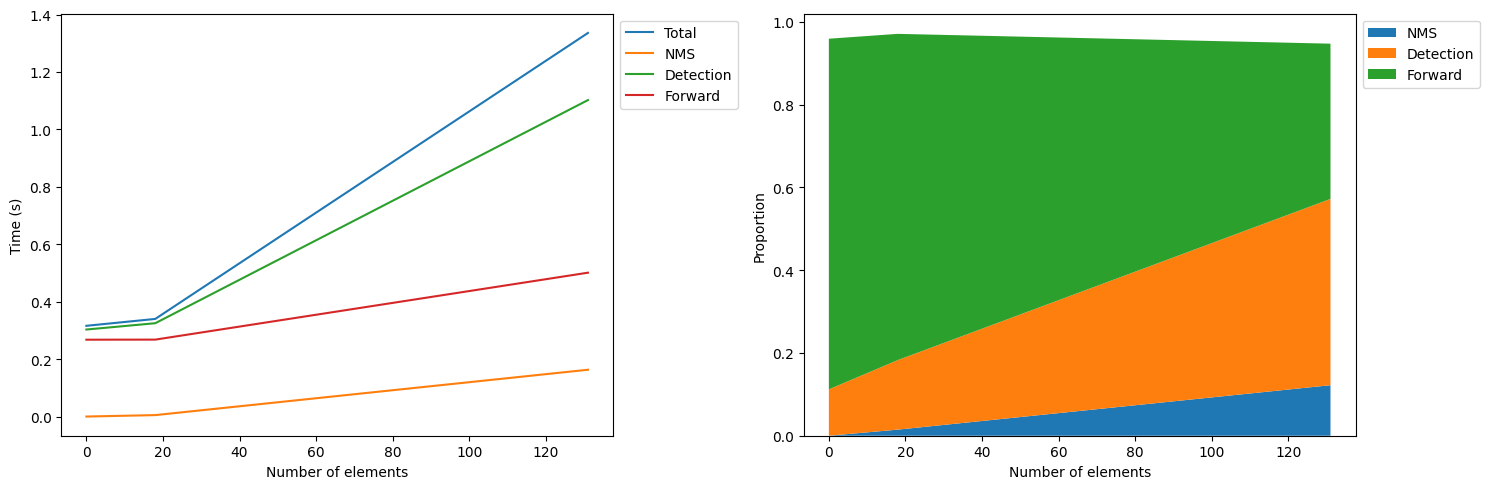

In [38]:

import re

data = """\
Processing: dev/input/20220723025959-17-snapshot.jpg | WxH: 3840 x 2160 | Area (MP): 8.2944
Prediction time: 1.066s/96.7% (overhead: 0.0) | Fetch 0.0% | Forward 46.9% | Postprocess 53.1%)
Total detection time: 1.102s (45.4% forward)
Combining 1 predictions into a single TensorPredictions object took 0.046 s | Duplication removal: 0.026 s | Mask combination: 0.020 s
Initializing TensorPredictions took 0.046 s
Non-maximum suppression took 0.163 s for removing 34 elements of 131 elements
Offsetting, scaling and padding took 0.001 s
Total pyramid time: 1.336s (82.5% detection | 37.5% forward)
WARNING: JSON (dev/output/20220723025959-17-snapshot/metadata_20220723025959-17-snapshot_UUID_None.json) already exists, overwriting!
WARNING: README (dev/output/20220723025959-17-snapshot/metadata_20220723025959-17-snapshot_UUID_None.md) already exists, overwriting!
Processing: dev/input/20230630001000-59-snapshot.jpg | WxH: 3840 x 2160 | Area (MP): 8.2944
Prediction time: 0.315s/97.1% (overhead: 0.0) | Fetch 0.0% | Forward 84.9% | Postprocess 15.1%)
Total detection time: 0.325s (82.4% forward)
Combining 1 predictions into a single TensorPredictions object took 0.006 s | Duplication removal: 0.003 s | Mask combination: 0.002 s
Initializing TensorPredictions took 0.006 s
Non-maximum suppression took 0.005 s for removing 5 elements of 18 elements
Offsetting, scaling and padding took 0.000 s
Total pyramid time: 0.340s (95.6% detection | 78.8% forward)
WARNING: JSON (dev/output/20230630001000-59-snapshot/metadata_20230630001000-59-snapshot_UUID_None.json) already exists, overwriting!
WARNING: README (dev/output/20230630001000-59-snapshot/metadata_20230630001000-59-snapshot_UUID_None.md) already exists, overwriting!
Processing: dev/input/20220721024000-16-snapshot.jpg | WxH: 3840 x 2160 | Area (MP): 8.2944
Prediction time: 0.822s/95.9% (overhead: 0.0) | Fetch 0.0% | Forward 32.6% | Postprocess 67.4%)
Total detection time: 0.857s (31.2% forward)
Combining 1 predictions into a single TensorPredictions object took 0.049 s | Duplication removal: 0.039 s | Mask combination: 0.009 s
Initializing TensorPredictions took 0.049 s
...
Total pyramid time: 0.316s (95.9% detection | 84.7% forward)
WARNING: JSON (dev/output/20220820030000-113-snapshot/metadata_20220820030000-113-snapshot_UUID_None.json) already exists, overwriting!
WARNING: README (dev/output/20220820030000-113-snapshot/metadata_20220820030000-113-snapshot_UUID_None.md) already exists, overwriting!
Average time: 1.114s\
"""

# Split the data into chunks after each line containing "Total pyramid time"
data = re.split(r'(?<= \d\d\.\d% forward\)\n)|(?<= \d\.\d% forward\)\n)|(?<= \d\.\d\d% forward\)\n)|(?<= \d\d% forward\)\n)|(?<= \d% forward\)\n)', data)[:-1] 

# Split each chunk into lines
data = [d.split("\n") for d in data]

# Define a function to extract the number of elements, total time as well as proportion of forward time
def extract_info(chunk):
    found_elements = False
    for line in chunk:
        if "Total pyramid time" in line:
            pline = line
            numbers = re.findall(r'[\d\.]+', line)
            total_time = float(numbers[0])
            detection_frac = float(numbers[1]) / 100
            forward_frac = float(numbers[2]) / 100
        elif "Non-maximum suppression" in line:
            numbers = re.findall(r'[\d\.]+', line)
            elements = int(numbers[-1])
            nms_time = float(numbers[0])
            if isinstance(elements, int):
                found_elements = True
    if not found_elements:
        elements = 0
        nms_time = 0
    # print(elements, numbers, pline)
    return elements, total_time, nms_time, detection_frac, forward_frac

# Extract the information from each chunk
info = [extract_info(d) for d in data]

# Transpose the data
info = np.array(list(zip(*info)))

# Sort the data by the number of elements
info = info[:, info[0].argsort()]
# Convert the percentage to a fraction
# Convert fractions to time in seconds
info[3:] *= info[1]

# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot the time used for detection and forward pass
x = info[0]
for i in range(len(info) - 1):
    ax[0].plot(x, info[i + 1], label=["Total", "NMS", "Detection", "Forward"][i])
# Place legend outside of the plot
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].set_ylabel("Time (s)")
ax[0].set_xlabel("Number of elements")
# Plot the proportion of time used for detection and forward pass
info[-2] -= info[-1]
ax[1].stackplot(x, info[2:] / info[1], labels=["NMS", "Detection", "Forward"])
# Place legend outside of the plot
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].set_ylabel("Proportion")
ax[1].set_xlabel("Number of elements")
plt.tight_layout()
plt.show()
# Total pyramid time: 39.565s (44% detection | 6.73% forward)

In [ ]:
test_loaded = TensorPredictions().load("test/original_20220730023959-130-snapshot/original_20220730023959-130-snapshot.json")
test_loaded.image = test.image

# test_loaded.plot_torch(outpath="test/test.jpg", linewidth=1, scale=1/2)
test_loaded.plot_opencv(outpath="test/test_loaded.jpg", linewidth=2, scale=1)
test.plot_opencv(outpath="test/test.jpg", linewidth=2, scale=1)

In [ ]:
from flat_bug.yolo_helpers import ios_masks_2sets, iou_masks_2sets, nms_masks

ios_mat = torch.cat([ios_masks_2sets(m, test.masks.data, dtype=dtype) for m in test.masks.data])
iou_mat = torch.cat([iou_masks_2sets(m, test.masks.data, dtype=dtype) for m in test.masks.data])

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow((ios_mat < _model.IOU_THRESHOLD).cpu().numpy())
axs[0].set_title("IoS")
axs[1].imshow((iou_mat < _model.IOU_THRESHOLD).cpu().numpy())
axs[1].set_title("IoU")
axs[2].imshow((ios_mat * iou_mat < _model.IOU_THRESHOLD).cpu().numpy())
axs[2].set_title("IoS * IoU")

In [ ]:
def expand_with_neighbors(indices, mx, my):
    # Initialize a list to store the expanded indices
    expanded_indices = []

    # Define the relative positions of the neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]

    # Iterate over each index pair and add its neighbors
    for x, y in indices:
        for dx, dy in neighbors:
            new_x, new_y = x + dx, y + dy
            new_x = min(max(new_x, 0), mx)
            new_y = min(max(new_y, 0), my)
            expanded_indices.append([new_x, new_y])

    # Convert the list of indices to a numpy array
    return np.array(expanded_indices)


In [ ]:
plt.figure(figsize=(10, 10))
ms = np.zeros(image.shape[1:]) # CxHxW
boxes = test._bboxes # x, y, w, h
print(ms.shape)
xys = np.concatenate(test.contours)
msx, msy = ms.shape
xys = expand_with_neighbors(expand_with_neighbors(xys, msy - 1, msx - 1), msy - 1, msx - 1)
ms[xys[:, 1], xys[:, 0]] = 1
# Permute to HxWxC (numpy)
# ms = ms.transpose(1, 2, 0)
plt.imshow(image.cpu().int().permute(1, 2, 0))
# plt.imshow(ms, alpha = .75)
for x, y, w, h in boxes:
    plt.gca().add_patch(mpl.patches.Rectangle((x, y), w, h, fill=False, edgecolor='r', linewidth=1))
plt.show()

In [ ]:
# def intersect_test(rect1, rect2s, area_only=False, debug=False):
#     """
#     Calculates the intersection of a rectangle with a set of rectangles.
#     """
#     if len(rect1.shape) == 1 and not rect1.shape[0] == 4 or len(rect1.shape) == 2 and not rect1.shape[1] == 4:
#         raise ValueError(f"Rectangles must be of shape (n, 4), not {rect1.shape}")
#     if len(rect2s.shape) == 1 and not rect2s.shape[0] == 4 or len(rect2s.shape) == 2 and not rect2s.shape[1] == 4:
#         raise ValueError(f"Rectangles must be of shape (n, 4), not {rect2s.shape}")
#     if len(rect1.shape) == 1:
#         rect1 = rect1.unsqueeze(0)
#     if len(rect2s.shape) == 1:
#         rect2s = rect2s.unsqueeze(0)

#     # Safer to enable this, but it is slower
#     # # Check the validity of the rectangles
#     # if not check_bltr_validity(rect1, debug):
#     #     rect1 = fix2btlr(rect1)
#     # if not check_bltr_validity(rect2s, debug):
#     #     rect2s = fix2btlr(rect2s)

#     # Calculate vectors from each corner of rect1 to each corner of rect2s
#     blbltrtr = rect2s - rect1
#     bl_to_bl = blbltrtr[:, :2]
#     tr_to_tr = blbltrtr[:, 2:] 
#     bltrtrbl = rect2s[:, [2, 3, 0, 1]] - rect1
#     bl_to_tr = bltrtrbl[:, :2]
#     tr_to_bl = bltrtrbl[:, 2:]
    
#     # Determine if each corner of rect1 is inside each rect2
#     inside_tr = (tr_to_tr[:, 0] >= 0) & (tr_to_tr[:, 1] >= 0) & (tr_to_bl[:, 0] <= 0) & (tr_to_bl[:, 1] <= 0)
#     inside_bl = (bl_to_bl[:, 0] <= 0) & (bl_to_bl[:, 1] <= 0) & (bl_to_tr[:, 0] >= 0) & (bl_to_tr[:, 1] >= 0)
#     inside_tl = (bl_to_bl[:, 0] <= 0) & (tr_to_tr[:, 1] >= 0) & (bl_to_tr[:, 0] >= 0) & (tr_to_bl[:, 1] <= 0)
#     inside_br = (tr_to_tr[:, 0] >= 0) & (bl_to_bl[:, 1] <= 0) & (tr_to_bl[:, 0] <= 0) & (bl_to_tr[:, 1] >= 0)

#     # Check for enclosure
#     enclosure = (rect1[:, :2] <= rect2s[:, :2]) & (rect1[:, 2:] >= rect2s[:, 2:])

#     # Check for intersection with the "infinitely" extended cross of rect1
#     in_cross = ((bl_to_bl[:, 0] <= 0) & (bl_to_tr[:, 0] >= 0)) | ((tr_to_tr[:, 0] >= 0) & (tr_to_bl[:, 0] <= 0)), ((bl_to_bl[:, 1] <= 0) & (bl_to_tr[:, 1] >= 0)) | ((tr_to_tr[:, 1] >= 0) & (tr_to_bl[:, 1] <= 0))

#     # Check for equality - if equal, return the original rectangles
#     zero = torch.tensor(0, dtype=rect1.dtype, device=rect1.device)
#     is_equal = (bl_to_bl.isclose(zero).all(dim=1)) & (tr_to_tr.isclose(zero).all(dim=1))

#     # Check for no intersection - if no intersection, return the intersection rectangle [0, 0, 0, 0]
#     is_intersecting = inside_tl | inside_br | inside_bl | inside_tr | (enclosure[:, 0] & in_cross[1]) | (enclosure[:, 1] & in_cross[0]) | (enclosure[:, 0] & enclosure[:, 1]) | is_equal

#     if not area_only:
#         intersections = is_intersecting.unsqueeze(1) * torch.cat((torch.max(rect1[:, :2], rect2s[:, :2]), torch.min(rect1[:, 2:], rect2s[:, 2:])), dim=1)
#         intersections[is_equal] = rect1
#     else:
#         intersections = torch.zeros(rect2s.shape[0], dtype=rect1.dtype, device=rect1.device)
#         intersections[is_intersecting] = (torch.min(rect1[:, 2:], rect2s[is_intersecting, 2:]) - torch.max(rect1[:, :2], rect2s[is_intersecting, :2])).abs().prod(dim=1)

#     if debug:
#         # Used for debugging
#         return intersections, torch.stack((inside_tl, inside_tr, inside_br, inside_bl), dim=1), enclosure, in_cross
#     else:
#         return intersections

def intersect_test(rect1, rect2s, **kwargs):
    # This implementation apparently gets the intersection area of two rectangles, perhaps it can be used to get the intersection rectangle as well
    # (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp_(0) \
    #     * \
    # (b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)).clamp_(0)
    # Rectangles are formatted as xmin, ymin, xmax, ymax
    def _inter1(b1, b2):
        b1_x1, b1_y1, b1_x2, b1_y2 = b1
        b2_x1, b2_y1, b2_x2, b2_y2 = b2

        ix1 = max(b1_x1, b2_x1)
        iy1 = max(b1_y1, b2_y1)
        ix2 = min(b1_x2, b2_x2)
        iy2 = min(b1_y2, b2_y2)

        # Check for no intersection
        if ix2 < ix1 or iy2 < iy1:
            return 0, 0, 0, 0
        
        return ix1, iy1, ix2, iy2
    
    def _inter2(b1, b2):
        """
        This time b1 and b2 are tensors
        """
        # Get the maximum of the minimum x and y values, to do this in a vectorized way we negate x1 and y1 and take the minimum, then negate the result. 
        b1[:2] *= -1
        b2[:2] *= -1
        i = torch.min(b1, b2)
        i[:2] *= -1
        b1[:2] *= -1
        b2[:2] *= -1
        # Check for no intersection
        return i * (~(i[2:] < i[:2]).any())
    
    def _inter3(b1, b2s):
        """
        Now b2s is a tensor of rectangles
        """
        ix_max = torch.max(b1[:2].unsqueeze(0), b2s[:, :2])
        ix_min = torch.min(b1[2:].unsqueeze(0), b2s[:, 2:])
        ix = torch.zeros_like(b2s)
        ix[:, :2] = ix_max
        ix[:, 2:] = ix_min
        # Check for no intersection
        ix[(ix_min < ix_max).any(dim=1)] = 0
        return ix
    
    def _inter4(b1, b2s):
        """
        Now vectorized, but with NumPy
        """
        ix_max = np.maximum(b1[:2], b2s[:, :2])
        ix_min = np.minimum(b1[2:], b2s[:, 2:])
        ix = np.zeros_like(b2s)
        ix[:, :2] = ix_max
        ix[:, 2:] = ix_min
        # Check for no intersection
        ix[(ix_min < ix_max).any(axis=1)] = 0
        return ix
    
    N = rect2s.shape[0]
    rect1 = rect1[0]
    _dtype, _device = rect1.dtype, rect1.device

    start = time.time()
    intersections_1 = torch.tensor([_inter1(rect1.tolist(), rect2.tolist()) for rect2 in rect2s], dtype=_dtype, device=_device)
    t1 = time.time() - start
    # print(f"Time for native Python: {t1:.3f}s")
    start = time.time()
    intersections_2 = torch.stack([_inter2(rect1, rect2) for rect2 in rect2s])
    t2 = time.time() - start
    # print(f"Time for PyTorch: {t2:.3f}s")
    start = time.time()
    intersections_3 = _inter3(rect1, rect2s)
    t3 = time.time() - start
    # print(f"Time for vectorized PyTorch: {t3:.3f}s")
    rect1 = rect1.numpy()
    rect2s = rect2s.numpy()
    start = time.time()
    intersections_4 = _inter4(rect1, rect2s)
    t4 = time.time() - start
    # print(f"Time for vectorized NumPy: {t4:.3f}s")

    # Check for correctnesss
    if not torch.all(intersections_1 == intersections_2):
        print("Error in _inter1 and _inter2")
    if not torch.all(intersections_1 == intersections_3):
        print("Error in _inter1 and _inter3")
    if not torch.all(intersections_1 == torch.tensor(intersections_4, dtype=_dtype, device=_device)):
        print("Error in _inter1 and _inter4")

    return t1, t2, t3, t4
    # return intersections_3, torch.zeros((N, 4)), torch.zeros((N, 2)), (torch.zeros(N) == 0, torch.zeros(N) == 0)

In [ ]:
r1 = torch.tensor([2, 2, 5, 5], dtype=torch.uint8, device=device)  # Rectangle 2 coordinates

number_of_rectangles = 2 ** torch.arange(1, 13)

times = torch.zeros((4, len(number_of_rectangles)))

for i, n in tqdm(enumerate(number_of_rectangles), total = len(number_of_rectangles)):
    r2s = torch.randint(0, 255, (n, 4), dtype=torch.int16, device=device)

    times[:, i] = torch.tensor([intersect_test(r1.unsqueeze(0), r2s) for _ in range(25)]).mean(dim=0) * 1000

plt.figure(figsize=(10, 5))

plt.plot(number_of_rectangles, times[0], label="Native Python")
plt.plot(number_of_rectangles, times[1], label="PyTorch")
plt.plot(number_of_rectangles, times[2], label="Vectorized PyTorch")
plt.plot(number_of_rectangles, times[3], label="Vectorized NumPy")

plt.gca().set_yscale("log")
plt.gca().set_xscale("log")

plt.legend()
plt.show()

In [ ]:
# Example usage
r2 = torch.tensor([2, 2, 5, 5], dtype=torch.int16, device=device)  # Rectangle 2 coordinates

xmins = [1, 2]
ymins = [1, 2]
xmaxs = [4, 5]
ymaxs = [4, 5]
# xmins = [1, 3]
# ymins = [1, 3]
# xmaxs = [4, 6]
# ymaxs = [4, 6]

# n_rects = len(xmins) * len(ymins) * len(xmaxs) * len(ymaxs)
# ncols = min(6, int(n_rects ** (1/2)))
# nrows = math.ceil(n_rects / ncols)

# fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

rectangles = []

for xmin, ymin, xmax, ymax in itertools.product(xmins, ymins, xmaxs, ymaxs):
    r11 = torch.tensor([xmin, ymin, xmax, ymax], dtype=r2.dtype, device=device)
    rectangles.append(r11.clone())

rectangles = torch.stack(rectangles)
rectangles = fix2btlr(rectangles)

intersections, corners, encs, crs = intersect_test(r2.unsqueeze(0), rectangles, debug=True)

# # Move tensors to cpu and convert to float
# rectangles = rectangles.detach().float().cpu().numpy()
# intersections = intersections.detach().float().cpu().numpy()
# corners = corners.detach().cpu()
# encs = encs.detach().cpu()
# crs = torch.stack(crs, dim=1).detach().cpu()
# r2 = r2.detach().float().cpu().numpy()

# for i, (ax, r1, inter) in enumerate(zip(axs.flatten(), rectangles, intersections)):
#     # IOU
#     a1 = (r1[2] - r1[0]) * (r1[3] - r1[1])
#     a2 = (r2[2] - r2[0]) * (r2[3] - r2[1])
#     ai = (inter[2] - inter[0]) * (inter[3] - inter[1])
#     iou = ai / (a1 + a2 - ai)

#     # Plot rect1
#     p1 = mpl.patches.Rectangle((r1[0], r1[1]), r1[2] - r1[0], r1[3] - r1[1], linewidth=3, edgecolor="r", facecolor="none", alpha=1)
#     # Plot rect2
#     p2 = mpl.patches.Rectangle((r2[0], r2[1]), r2[2] - r2[0], r2[3] - r2[1], linewidth=3, edgecolor="b", facecolor="none", alpha=1)

#     # Plot the intersection
#     if inter.sum() > 0:
#         p3 = mpl.patches.Rectangle((inter[0], inter[1]), inter[2] - inter[0], inter[3] - inter[1], linewidth=0, edgecolor="none", facecolor="g", alpha=0.5)
#         ax.add_patch(p3)
#         icenter = (inter[2:] + inter[:2]) / 2
#         ax.text(icenter[0], icenter[1], f"{iou:.2f}", color="g", fontsize=12, ha="center", va="center")
#     ax.add_patch(p1)
#     ax.add_patch(p2)

#     ax.set_xlim([0, 8])
#     ax.set_ylim([0, 8])
#     # ax.set_xticks([])
#     # ax.set_yticks([])
#     ax.set_title("i: " + str(i) + " | co: " + ",".join(["T" if c.item() else "F" for c in corners[i]]) + " | en: " +  ",".join(["T" if e.item() else "F" for e in encs[i]]) + " | cr: " +  ",".join(["T" if c.item() else "F" for c in crs[i]]), fontsize=11)

# plt.tight_layout()
# plt.show()
